In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
import timm
import os
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import Adam
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from collections import Counter
import os
from PIL import Image
import numpy as np


In [22]:

# Define class labels
class_labels = {
    "Hatchback": 0,
    "Other": 1,
    "Pickup": 2,
    "Sedan": 3,
    "SUV": 4
}


In [23]:

# Define image size
IMG_SIZE = 224


In [24]:
# Função para analisar as imagens
def analyze_images(image_dir):
    dataset = ImageFolder(image_dir)
    
    # Contar as classes
    class_counts = Counter([item[1] for item in dataset.imgs])
    
    # Tamanho das imagens
    image_sizes = [Image.open(item[0]).size for item in dataset.imgs]
    
    # Tamanho médio das imagens
    avg_width = np.mean([size[0] for size in image_sizes])
    avg_height = np.mean([size[1] for size in image_sizes])
    
    # Exibir resultados
    print(f"Total number of images: {len(dataset)}")
    print(f"Class distribution: {class_counts}")
    print(f"Average image size: {avg_width:.2f} x {avg_height:.2f}")
    
    # Plotar distribuição das classes
    plt.bar(class_counts.keys(), class_counts.values(), tick_label=[dataset.classes[i] for i in class_counts.keys()])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

Total number of images: 4793
Class distribution: Counter({2: 1689, 4: 1222, 3: 680, 0: 602, 1: 600})
Average image size: 375.81 x 291.92


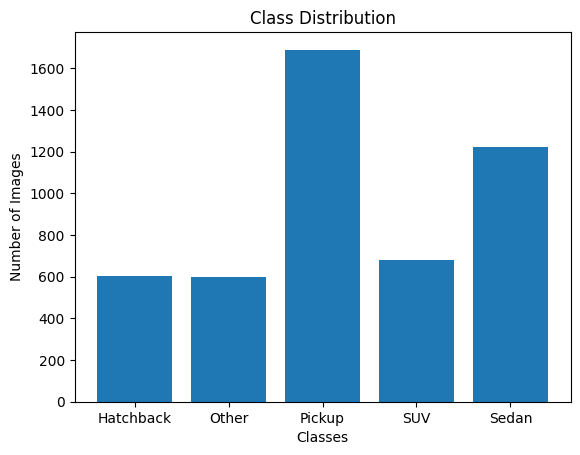

In [25]:
image_dir = './vehicles'  
# Analisar o dataset
analyze_images(image_dir)

In [26]:

# Preprocess images and labels
def preprocess_data(image_dir, class_labels, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = ImageFolder(image_dir, transform=transform)
    
    # Split dataset into train/test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Create DataLoader for train and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [27]:

def generate_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            features = model.forward_features(images)  # forward_features para o modelo ViT do timm
            embeddings.append(features)
            targets.append(labels)
    embeddings = torch.cat(embeddings)
    targets = torch.cat(targets)
    return embeddings, targets


In [28]:

# Definição do MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [29]:

# Função para treinar o modelo com early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [30]:

# Função para avaliar o modelo
def evaluate_model(model, test_embeddings, test_targets, device):
    model.eval()
    with torch.no_grad():
        outputs = model(test_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total = test_targets.size(0)
        correct = (predicted == test_targets).sum().item()

        # Cálculo de métricas adicionais
        precision = precision_score(test_targets.cpu(), predicted.cpu(), average='macro')
        recall = recall_score(test_targets.cpu(), predicted.cpu(), average='macro')
        f1 = f1_score(test_targets.cpu(), predicted.cpu(), average='macro')
        conf_matrix = confusion_matrix(test_targets.cpu(), predicted.cpu())

    accuracy = 100 * correct / total
    return accuracy, precision, recall, f1, conf_matrix


In [31]:
train_loader, test_loader = preprocess_data(image_dir, class_labels)


In [32]:

# Criar o modelo ViT pré-treinado
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = vit_model.to(device)


In [33]:

train_embeddings, train_targets = generate_embeddings(train_loader, vit_model, device)
test_embeddings, test_targets = generate_embeddings(test_loader, vit_model, device)

input_dim = train_embeddings.shape[1]
output_dim = len(class_labels)


KeyboardInterrupt: 

In [ ]:

# Criar MLP
mlp = MLP(input_dim, hidden_dim=512, output_dim=output_dim).to(device)


In [ ]:

# Função de Loss, Otimizador e epochs
criterion = nn.CrossEntropyLoss()
optimizer = Adam(mlp.parameters())
num_epochs = 100
early_stopping = EarlyStopping(patience=5, verbose=True)


In [ ]:

# Inicializar listas para monitorar perda e acurácia
train_loss = []
valid_loss = []


In [ ]:

# Avaliar o modelo antes do treinamento
print("Avaliação antes do treinamento:")
initial_accuracy, initial_precision, initial_recall, initial_f1, initial_conf_matrix = evaluate_model(mlp, test_embeddings, test_targets, device)
print(f'Initial Test Accuracy: {initial_accuracy:.2f} %')
print(f'Initial Precision: {initial_precision:.2f}')
print(f'Initial Recall: {initial_recall:.2f}')
print(f'Initial F1-Score: {initial_f1:.2f}')
print('Initial Confusion Matrix:')
print(initial_conf_matrix)


In [ ]:

# Treinar o MLP com early stopping
for epoch in range(num_epochs):
    mlp.train()
    train_embeddings = train_embeddings.to(device)
    train_targets = train_targets.to(device)

    # Forward pass
    outputs = mlp(train_embeddings)
    loss = criterion(outputs, train_targets)

    # Backward e optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Salvar a perda de treinamento
    train_loss.append(loss.item())

    # Validação
    mlp.eval()
    with torch.no_grad():
        outputs = mlp(train_embeddings)
        loss = criterion(outputs, train_targets)
        valid_loss.append(loss.item())

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    early_stopping(loss, mlp)
    if early_stopping.early_stop:
        print("Early stopping")
        break


In [ ]:

# Visualizar histórico de perda
epoch_count = range(1, len(train_loss) + 1)
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:

# Carregar o melhor modelo salvo durante o early stopping
mlp.load_state_dict(torch.load('checkpoint.pt'))


In [ ]:

# Avaliar o modelo após o treinamento
print("Avaliação após o treinamento:")
final_accuracy, final_precision, final_recall, final_f1, final_conf_matrix = evaluate_model(mlp, test_embeddings, test_targets, device)
print(f'Final Test Accuracy: {final_accuracy:.2f} %')
print(f'Final Precision: {final_precision:.2f}')
print(f'Final Recall: {final_recall:.2f}')
print(f'Final F1-Score: {final_f1:.2f}')
print('Final Confusion Matrix:')
print(final_conf_matrix)
